In [ ]:
%pip install matplotlib
%pip install box2d
%pip install gymnasium
%pip install opencv-python==4.10.0.84
!apt-get update && apt-get install -y libgl1

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# matplotlib 설정
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# GPU를 사용할 경우
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """transition 저장"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

[25.        3.        0.        0.       30.127947  3.        0.
  0.       19.872053  3.        0.        0.      ] {'winner': None}


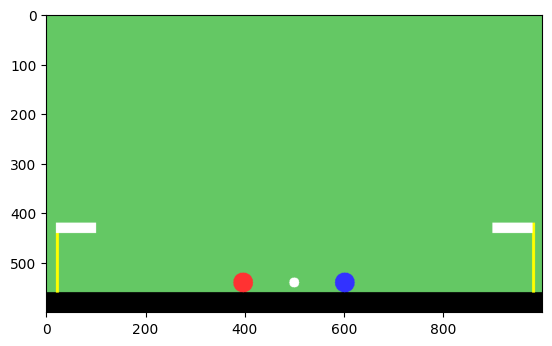

In [3]:
import soccer_env

env = gym.make("SoccerEnv", render_mode="rgb_array")
env = gym.wrappers.FlattenObservation(env)

state, info = env.reset()

frame = env.render()
plt.imshow(frame)

print(state, info)

In [4]:
STATE_SCALE = np.array([50, 30, 30, 30, 50, 30, 30, 30, 50, 30, 30, 30])
STATE_SCALE = torch.tensor(np.ones_like(STATE_SCALE) / STATE_SCALE, device=device).unsqueeze(0)

def preprocess_state(state, label):
    state = state.clone().detach()

    state *= STATE_SCALE
    if label == "Player1":
        state[:, 0:2] -= state[:, 4:6]
        state[:, 8:10] -= state[:, 4:6]
    if label == "Player2":
        state[:, 0:2] -= state[:, 8:10]
        state[:, 4:6] -= state[:, 8:10]
    
    return state

preprocess_state(torch.tensor(state, device=device).unsqueeze(0), "Player1")

tensor([[-0.1026,  0.0000,  0.0000,  0.0000,  0.6026,  0.1000,  0.0000,  0.0000,
         -0.2051,  0.0000,  0.0000,  0.0000]])

In [5]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions, label):
        super(DQN, self).__init__()
        d_model = 5
        self.layer1 = nn.Linear(n_observations, d_model)
        self.layer2 = nn.Linear(d_model, d_model)
        self.layer3 = nn.Linear(d_model, n_actions)

        self.label = label

    # 최적화 중에 다음 행동을 결정하기 위해서 하나의 요소 또는 배치를 이용해 호촐됩니다.
    # ([[left0exp,right0exp]...]) 를 반환합니다.
    def forward(self, x):
        x = preprocess_state(x, self.label)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [6]:
# BATCH_SIZE는 리플레이 버퍼에서 샘플링된 트랜지션의 수입니다.
# GAMMA는 이전 섹션에서 언급한 할인 계수입니다.
# EPS_START는 엡실론의 시작 값입니다.
# EPS_END는 엡실론의 최종 값입니다.
# EPS_DECAY는 엡실론의 지수 감쇠(exponential decay) 속도 제어하며, 높을수록 감쇠 속도가 느립니다.
# TAU는 목표 네트워크의 업데이트 속도입니다.
# LR은 ``AdamW`` 옵티마이저의 학습율(learning rate)입니다.
BATCH_SIZE = 128
GAMMA = 0.8
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

class ModelSettings:
    def __init__(self, model, n_observations, action_space, **kwargs):
        self.action_space = action_space
        n_actions = action_space.n

        self.policy_net = model(n_observations, n_actions, **kwargs).to(device)
        self.target_net = model(n_observations, n_actions, **kwargs).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
        self.memory = ReplayMemory(10000)

        self.steps_done = 0
        
    def select_action(self, state, eval=False):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * self.steps_done / EPS_DECAY)
        if eval:
            eps_threshold = EPS_END
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max (1)은 각 행의 가장 큰 열 값을 반환합니다.
                # 최대 결과의 두번째 열은 최대 요소의 주소값이므로,
                # 기대 보상이 더 큰 행동을 선택할 수 있습니다.
                return self.policy_net(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[self.action_space.sample()]], device=device, dtype=torch.long)
    
    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). 이것은 batch-array의 Transitions을 Transition의 batch-arrays로
        # 전환합니다.
        batch = Transition(*zip(*transitions))

        # 최종이 아닌 상태의 마스크를 계산하고 배치 요소를 연결합니다
        # (최종 상태는 시뮬레이션이 종료 된 이후의 상태)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Q(s_t, a) 계산 - 모델이 Q(s_t)를 계산하고, 취한 행동의 열을 선택합니다.
        # 이들은 policy_net에 따라 각 배치 상태에 대해 선택된 행동입니다.
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # 모든 다음 상태를 위한 V(s_{t+1}) 계산
        # non_final_next_states의 행동들에 대한 기대값은 "이전" target_net을 기반으로 계산됩니다.
        # max(1).values로 최고의 보상을 선택하십시오.
        # 이것은 마스크를 기반으로 병합되어 기대 상태 값을 갖거나 상태가 최종인 경우 0을 갖습니다.
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values
        # 기대 Q 값 계산
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch.squeeze(1)

        # Huber 손실 계산
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # 모델 최적화
        self.optimizer.zero_grad()
        loss.backward()
        # 변화도 클리핑 바꿔치기
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def update_target_net(self):
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        self.target_net.load_state_dict(target_net_state_dict)

state, info = env.reset()
n_observations = len(state)

setting1 = ModelSettings(DQN, n_observations, env.action_space[0], label="Player1")
setting2 = ModelSettings(DQN, n_observations, env.action_space[1], label="Player2")

In [7]:
episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)

    ax = plt.subplot(2, 2, 1)

    durations_t = torch.tensor(episode_durations, dtype=torch.float)

    ax.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [15]:
import cv2

num_episodes = 100

for i_episode in range(num_episodes):
    # 환경과 상태 초기화
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action1 = setting1.select_action(state)
        action2 = setting2.select_action(state, eval=True)
        observation, reward, terminated, truncated, info = env.step((action1.item(), action2.item()))

        if True:
            frame = env.render()
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            cv2.imshow('Env', frame_bgr)
            cv2.waitKey(1)
            #ax = plt.subplot(2, 2, 2)
            #ax.imshow(frame)
            #plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
            #if is_ipython:
            #    display.display(plt.gcf())
            #    display.clear_output(wait=True)

        #if t == 300:
        #    truncated = True

        d1 = torch.norm(state[0][0:2] - state[0][4:6]).item()
        d2 = torch.norm(state[0][0:2] - state[0][8:10]).item()
        
        d3 = np.linalg.norm(observation[0:2] - observation[4:6])
        d4 = np.linalg.norm(observation[0:2] - observation[8:10])

        reward1 = int(info["winner"] == "Player1") * 10
        reward2 = int(info["winner"] == "Player2") * 10
        reward1, reward2 = (reward1 - reward2, reward2 - reward1)
        reward1 += (d1 - d3)
        reward2 += (d2 - d4)
        reward = torch.tensor([reward1, reward2], device=device)

        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # 메모리에 변이 저장
        setting1.memory.push(state, action1, next_state, reward[0].view(1, 1))
        setting2.memory.push(state, action2, next_state, reward[1].view(1, 1))

        # 다음 상태로 이동
        state = next_state

        # (정책 네트워크에서) 최적화 한단계 수행
        #setting1.optimize_model()
        #setting2.optimize_model()

        ## 목표 네트워크의 가중치를 소프트 업데이트
        ## θ′ ← τ θ + (1 −τ )θ′
        #setting1.update_target_net()
        #setting2.update_target_net()

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            print(reward)
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

tensor([-0.0217, -0.0228], dtype=torch.float64)


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [14]:
setting1.policy_net.load_state_dict(torch.load('model1-7.pth', map_location='cpu'))
setting1.policy_net.eval()

setting2.policy_net.load_state_dict(torch.load('model2-8.pth', map_location='cpu'))
setting2.policy_net.eval()

DQN(
  (layer1): Linear(in_features=12, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=5, bias=True)
  (layer3): Linear(in_features=5, out_features=5, bias=True)
)